In [148]:
import pandas as pd
import copy

input_file_name = "input.json"
import json
with open(input_file_name) as f:
  input_data = json.load(f)
input_data = input_data["data"]

# Optional extra parameters
if "extra_arguments" in input_data:
    extra_arguments = input_data['extra_arguments']
else:
    extra_arguments = {}

if "solver_params" in input_data:
    solver_params = input_data['solver_params']
else:
    solver_params = {}


from_=input_data['from']
to_=input_data['to']
assets=input_data['assets']
dfs=[]
for asset in assets:
    dfs.append(pd.Series(assets[asset]['history'],name=asset))
df=pd.concat(dfs,axis=1).bfill().pct_change()
ini=1
results={}
results[max([x for x in df.index.tolist() if x<from_])]=ini
for t in [ x for x in df.index.tolist() if x>=from_ and x<=to_]:
    d={}
    d['num_assets']=input_data['num_assets']
    assets_=copy.deepcopy(assets)
    for asset in assets_:
        assets_[asset]['history']={x:assets_[asset]['history'][x] for x in assets_[asset]['history'] if x<t}
    d['assets']=assets_
    d['evaluation_date']=t

In [149]:
"""
    Our code starts here. d is the only input to the "portfolio.py". Takes 'budget'
"""

filtering_number = 3

asset_names = list(d["assets"].keys())
L = len(asset_names)
p = [list(d['assets'][name]['history'].values()) for name in asset_names] # Stock prices over time
P = [p[i][-1] if len(p[i])!=0 else 0 for i in range(L)] # Current Stock Prices

In [150]:
import numpy as np

# Expected Return:
r = [[(p[i][t]-p[i][t-1])/p[i][t-1] if t>0 else 0 for t in range(len(p[i]))] for i in range(len(p))]
mu = []
for i in range(L):
    exp = np.sum(np.array([r[i][t] for t in range(len(r[i]))])) / len(r[i])
    if not np.isnan(exp):
        mu.append(exp)
    else:
        mu.append(-1)


# We take only the highest 10 expected returns and will optimize over them.
# This can be user defined parameter. As the quantum computer scales up,
# we'll be able to increase this number.
indices = np.argsort(mu)
mu_filtered = []
r_filtered = []
p_filtered = []
for index in indices[-filtering_number:]:
    mu_filtered.append(mu[index])
    r_filtered.append(r[index])
    p_filtered.append(p[index])

mu = mu_filtered
r = r_filtered
L = filtering_number
p = p_filtered
P = [p[i][-1] for i in range(L)]

# Variance Matrix:

Sigma = [
    [   np.sum(np.array([
        (r[i][t]-mu[i])*(r[j][t]-mu[j]) for t in range( min( len(r[i]),  len(r[j])) )
    ]))/(len(r[i]) - 1)
        for j in range(L)
    ] for i in range(L)
]

/tmp/ipykernel_26941/501911505.py:7: RuntimeWarning: invalid value encountered in scalar divide
  exp = np.sum(np.array([r[i][t] for t in range(len(r[i]))])) / len(r[i])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


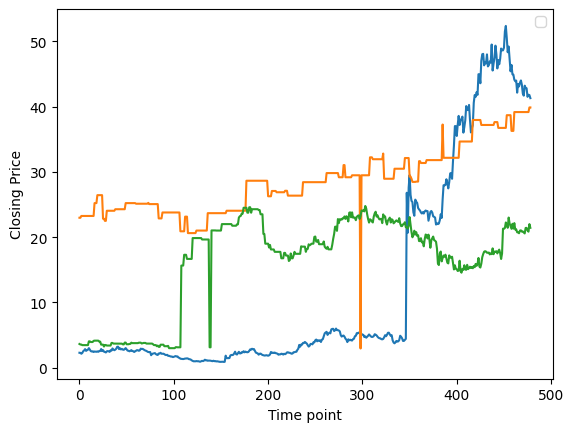

In [151]:
import matplotlib.pyplot as plt

for i in range(L):
    plt.plot(p[i])
plt.legend()
plt.xlabel("Time point")
plt.ylabel("Closing Price")
plt.show()

In [154]:
# Function to determine how many digits/qubit 
# we allocate for each asset.

N = 8 # User input.

N = N - 1
B = 2**((np.sum(np.array([np.log(price)/np.log(2) for price in P])) + N)/filtering_number) 
n_max = [np.floor(B/P[i]) for i in range(L)]
if 0.0 in n_max:
    B += np.sum(np.array(P)) # If after the initial filtering the automatically calculated budget is lower than the 
                             # the most expensive stock price, we put a base budget of allowing at least one stock
                             # purchase for each asset.
    n_max = [np.floor(B/P[i]) for i in range(L)]
    
D = [np.ceil(np.log(n_max[i])/np.log(2)) for i in range(L)]
N = int(np.sum(np.array(D)))

In [156]:
N

7

In [92]:
# To better optimize the process, we include the budget constraint and the fact that only
# an integer multiple of each stock can be bought. This is to avoid unspent budget/overspending.

P_p = [P[i]/B for i in range(L)]
mu_p = [mu[i]*P_p[i] for i in range(L)]
Sigma_p = [[P_p[i]*P_p[j]*Sigma[i][j] for j in range(L)] for i in range(L)]

# Convert to Binary transformation.
C = [[] for i in range(L)]
for i in range(L):
    for j in range(i):
        C[i] += [0]*int(D[j])
    C[i] += [2**d for d in range(int(D[i]))]
    for j in range(i+1, L):
        C[i] += [0]*int(D[j])
C = np.array(C)

mu_pp = C.T @ mu_p
Sigma_pp = C.T @ Sigma_p @ C
P_pp = C.T @ P_p

# Ising Implementation:
q = 1 # Risk aversion factor.
lamb = 10 # Small budget penalty param.

Sigma_pp = np.array(Sigma_pp)
J = q/4 * Sigma_pp
h = [-0.5*mu_pp[i] + 0.5*q*(Sigma_pp@np.array([1 for j in range(N)]))[i] for i in range(N)]
pi = [P_pp[i]/2 for i in range(N)]
beta = 1 - np.sum(np.array([P_pp[i]/2 for i in range(N)]))

In [93]:
# Cost Function for the classical optimization, binary formulation.
# Classical Optimization
from scipy.optimize import brute

def classical_cost_b(b, q, lamb, mu_pp, Sigma_pp, P_pp):
    return -(np.dot(mu_pp, b) - q * np.dot(b, Sigma_pp @ b) - lamb*(np.dot(P_pp, b) - 1)**2)

ranges = [slice(0, 2, 1) for i in range(N)]
binary_result = brute(lambda b: classical_cost_b(b, q, lamb, mu_pp, Sigma_pp, P_pp), ranges, disp=True, finish=None)
result = C@binary_result
B_spent = np.sum(np.array([result[i]*P[i] for i in range(L)]))

print("Budget Spent: ", B_spent)
print("Optimal Portfolio: ", result)
print("Cost: ", classical_cost_b(binary_result, q, lamb, mu_pp, Sigma_pp, P_pp))

Budget Spent:  164.45807266235352
Optimal Portfolio:  [2. 1. 2.]
Cost:  0.014905108832414785


In [96]:
from numpy import linalg as LA

Z = np.array([[1.,  0.], [0., -1.]])
I = np.identity(2)

hamil1 = 0 * np.identity(2**N)
for i in range(N):
    for j in range(N):
        Z_exp1 = np.identity(1)
        for _ in range(i):
            Z_exp1 = np.kron(Z_exp1, I)
        Z_exp1 = np.kron(Z_exp1, Z)
        for _ in range(i+1, N):
            Z_exp1 = np.kron(Z_exp1, I)

        Z_exp2 = np.identity(1)
        for _ in range(j):
            Z_exp2 = np.kron(Z_exp2, I)
        Z_exp2 = np.kron(Z_exp2, Z)
        for _ in range(j+1, N):
            Z_exp2 = np.kron(Z_exp2, I)
        Z_exp = Z_exp1 @ Z_exp2
        hamil1 = hamil1 + J[i][j] * Z_exp


hamil2 = 0 * np.identity(2**N)
for i in range(N):
    Z_exp = np.identity(1)
    for _ in range(i):
        Z_exp = np.kron(Z_exp, I)
    Z_exp = np.kron(Z_exp, Z)
    for _ in range(i+1, N):
        Z_exp = np.kron(Z_exp, I)
    hamil2 = hamil2 + h[i] * Z_exp
hamil = hamil1 + hamil2


penal = 0 * np.identity(2**N)
for i in range(N):
    Z_exp = np.identity(1)
    for _ in range(i):
        Z_exp = np.kron(Z_exp, I)
    Z_exp = np.kron(Z_exp, Z)
    for _ in range(i+1, N):
        Z_exp = np.kron(Z_exp, I)
    penal = penal + pi[i] * Z_exp
penal = penal - beta * np.identity(2**N)
penal = penal @ penal
hamil = hamil + lamb * penal

eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
print("Ground State Energy: ", eigenvalues_sort[0])
print("First Excited Energy: ", eigenvalues_sort[1])
print("Highest Energy: ", eigenvalues_sort[-1])

i = 0
for comp in ground_state:
    if np.abs(np.abs(comp) - 1) < 1e-6:
        break
    else:
        i = i+1

b_Ising = []
for ch in format(i, f'0{N}b'):
    b_Ising.append(0 if ch == '1' else 1)
b_Ising = np.array(b_Ising)

print("Optimal Portfolio: ", C@b_Ising)

Ground State Energy:  -0.015275192103497716
First Excited Energy:  -0.007370499961291871
Highest Energy:  19.135578323864312
Optimal Portfolio:  [2 1 2]


Initial overlaps:  0.010880877441684308


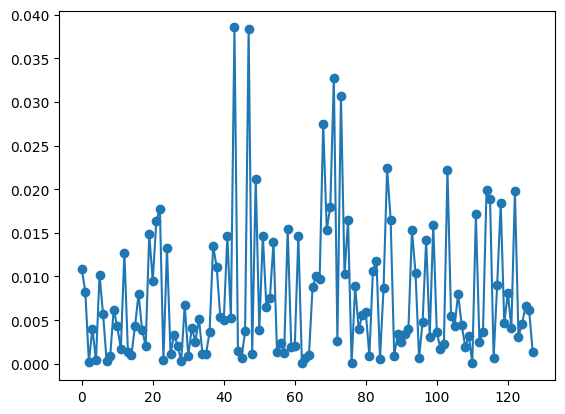

In [118]:
# We randomize the initial state.

from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import random_statevector


vec = random_statevector(2**N)
toPlot = [state_fidelity(vec, eigenvectors_sort[:, i]) for i in range(2**N)]
plt.plot([i for i in range(len(toPlot))], toPlot)
plt.scatter([i for i in range(len(toPlot))], toPlot)
print("Initial overlaps: ", state_fidelity(vec, eigenvectors_sort[:, 0]))

plt.show()

In [98]:
# Trotter Encoding of the Ising Hamiltonian.
import scipy
import qiskit
from qiskit import Aer, execute, transpile


def trotterized_time_evolution(J, h, pi, lamb, beta, t, L):
    qc = qiskit.QuantumCircuit(L)

    gates = []
    for i in range(L):
        for j in range(i+1, L):
            hloc = (J[i][j] + J[j][i] + 2*lamb*pi[i]*pi[j]) * np.kron(Z, Z)
            qc2 = qiskit.QuantumCircuit(2)
            qc2.unitary(scipy.linalg.expm(-1j*t*0.5*hloc), [0, 1], label='str')
            gates.append((qc2, [L-i-1, L-j-1]))
            qc.append(gates[-1][0].to_gate(), gates[-1][1])
    gates.reverse()
    for gate in gates:
        qc.append(gate[0].to_gate(), gate[1])

    for i in range(L):
        qc.rz(2*t*(h[i] - 2*beta*lamb*pi[i]), L-i-1)

    qc.p(
        -t*(lamb*beta**2+np.sum(np.array([J[i][i] + lamb*pi[i]*pi[i] for i in range(L)]))), L-1
    )
    qc.x(L-1)
    qc.p(
        -t*(lamb*beta**2+np.sum(np.array([J[i][i] + lamb*pi[i]*pi[i] for i in range(L)]))), L-1
    )
    qc.x(L-1)
    return qc

dt:  1.0
Running decomposition of two-qubit gates of the RQC Circuit...
dt:  1.0
Running decomposition of two-qubit gates of the RQC Circuit...
dt:  1.0
Running decomposition of two-qubit gates of the RQC Circuit...
dt:  1.0
Running decomposition of two-qubit gates of the RQC Circuit...
dt:  1.0
Running decomposition of two-qubit gates of the RQC Circuit...
dt:  1.0
Running decomposition of two-qubit gates of the RQC Circuit...
dt:  1.0
Running decomposition of two-qubit gates of the RQC Circuit...


/tmp/ipykernel_26941/4269400441.py:51: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  bR = execute(transpile(qc_RQC), backend).result().get_statevector().data


Projecting the ancilla qubit onto 0 with success prob:  0.28101450346361667
0.03420020710714285


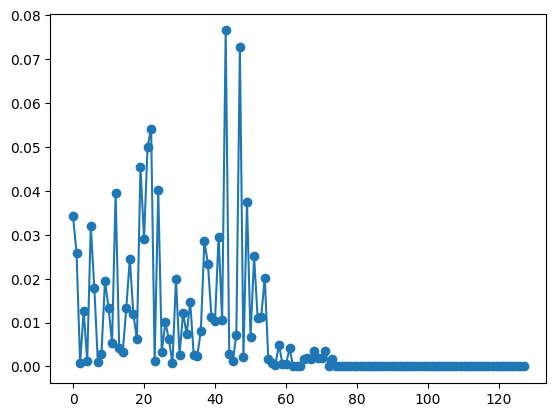

Projecting the ancilla qubit onto 0 with success prob:  0.5188731605860546
0.05817710146203875


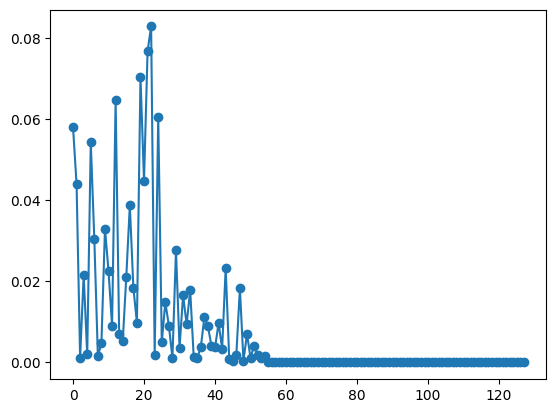

Projecting the ancilla qubit onto 0 with success prob:  0.6274923202718633
0.08165448478829326


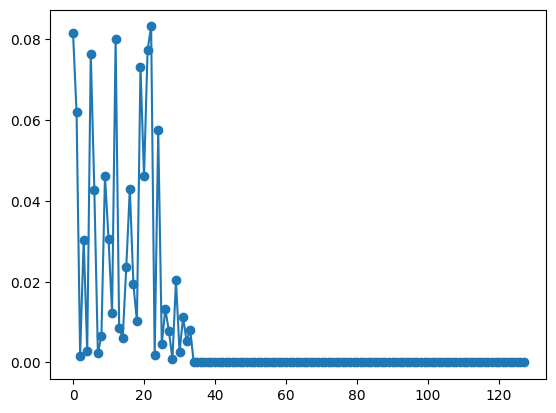

Projecting the ancilla qubit onto 0 with success prob:  0.5719475521435146
0.12504740383193377


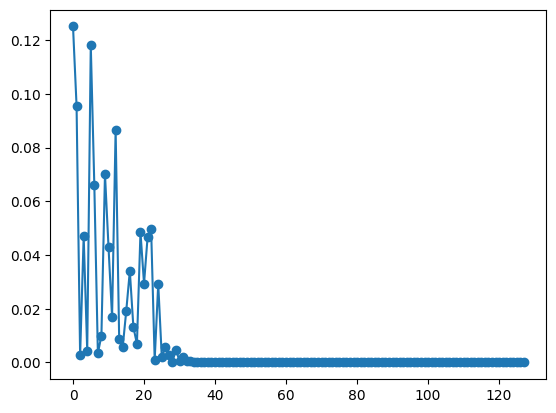

Projecting the ancilla qubit onto 0 with success prob:  0.5888785822916899
0.18406532085389019


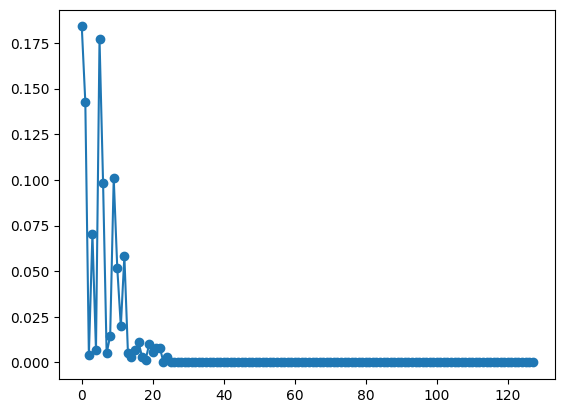

Projecting the ancilla qubit onto 0 with success prob:  0.7534811759560996
0.20877405505056973


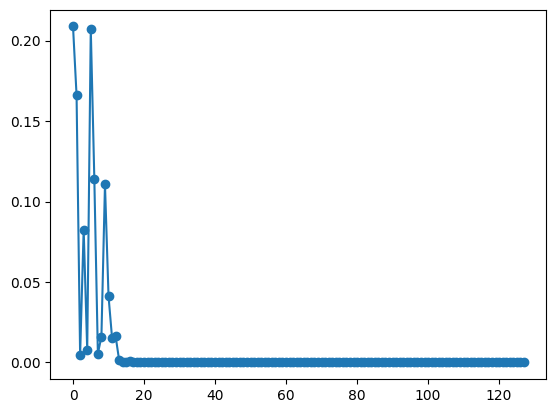

Projecting the ancilla qubit onto 0 with success prob:  0.8235721778952799
0.2136664627380858


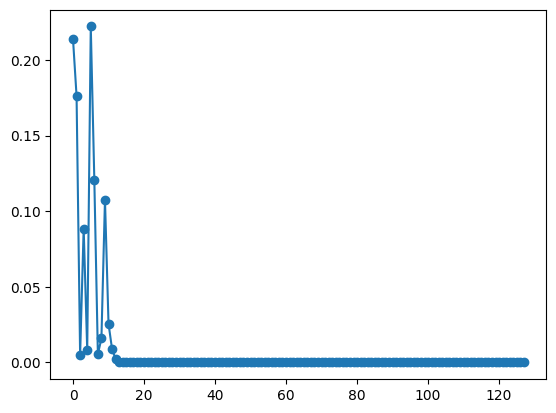

In [125]:
import sys
sys.path.append("./src/groundstate_prep")
sys.path.append("./src/rqcopt")
from ground_state_prep_qiskit import qetu_rqc_oneLayer

spectrum_upper_bound = 30
M = 7 # Number of filtering sequences.

ket_0 = np.array([1, 0])
qcs_qetu = []

for i in range(M):
    spectrum_upper_bound = spectrum_upper_bound/2
    spectrum_lower_bound = -1
    max_spectrum_length = spectrum_upper_bound - spectrum_lower_bound
    c1 = (np.pi) / (max_spectrum_length)
    c2 = - c1 * spectrum_lower_bound
    
    eigenvalues_tr = eigenvalues_sort * c1 + c2
    a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])
    
    # Time evolution block:
    t = c1
    qc_U = qiskit.QuantumCircuit(N)
    qc_U_dag = qiskit.QuantumCircuit(N)
    nsteps = 1
    for n in range(nsteps):
        qc_U.append(trotterized_time_evolution(J, h, pi, lamb, beta, t/nsteps, N).to_gate(), [i for i in range(N)])
        qc_U_dag.append(trotterized_time_evolution(J, h, pi, lamb, beta, -t/nsteps, N).to_gate(), [i for i in range(N)])
    
    qc_cU = qiskit.QuantumCircuit(N+1)
    qc_cU.append(qc_U.to_gate().control(), [N] + [i for i in range(N)])
    qc_cU_dag = qiskit.QuantumCircuit(N+1)
    qc_cU_dag.append(qc_U_dag.to_gate().control(), [N] + [i for i in range(N)])
    qc_cfUs = [qc_cU, qc_cU_dag]
    
    # QETU Circuit:
    mu, d, c, phis_max_iter, = (0.99, 30, 0.95, 10)
    qc_qetu, _ = qetu_rqc_oneLayer(N, 0, 0, 1, mu, d=d, c2=c2,
                                    qc_cU_custom=(qc_cfUs[0], qc_cfUs[1])
                                    )
    qcs_qetu.append(qc_qetu)

backend = Aer.get_backend("statevector_simulator")
qc_RQC = qiskit.QuantumCircuit(N+1, N+1)
aR = np.kron(ket_0, vec)
for qc_qetu in qcs_qetu:
    qc_RQC = qiskit.QuantumCircuit(N+1, N+1)
    qc_RQC.initialize(aR)
    qc_RQC.append(qc_qetu.to_gate(), [i for i in range(N+1)])
    bR = execute(transpile(qc_RQC), backend).result().get_statevector().data
    aR = np.kron(np.array([[1,0],[0,0]]), np.identity(2**N)) @ bR
    print("Projecting the ancilla qubit onto 0 with success prob: ", np.linalg.norm(aR)**2)
    aR = aR / np.linalg.norm(aR)

    toPlot = [state_fidelity(aR[:2**N], eigenvectors_sort[:, i]) for i in range(2**N)]
    print(toPlot[0])
    plt.plot([i for i in range(len(toPlot))], toPlot)
    plt.scatter([i for i in range(len(toPlot))], toPlot)
    plt.show()

In [102]:
from qiskit.providers.aer.noise import NoiseModel, errors

qc_RQC.measure([i for i in range(N)], [i for i in range(N)])

backend = Aer.get_backend("aer_simulator")
shots = 1e3
counts = execute(transpile(qc_RQC), backend, shots=shots).result().get_counts()

/tmp/ipykernel_26941/3656539104.py:7: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  counts = execute(transpile(qc_RQC), backend, shots=shots).result().get_counts()


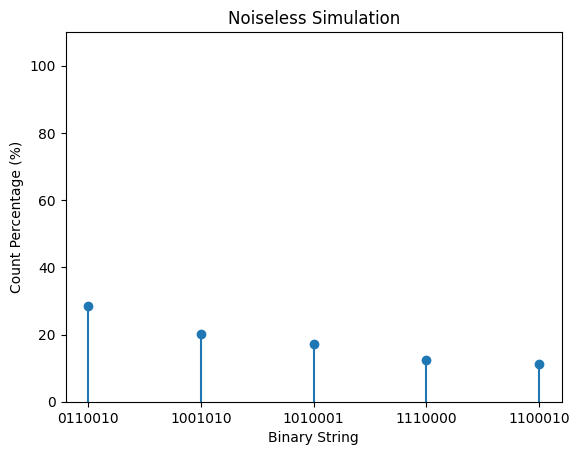

In [104]:
plt.xlabel("Binary String")
plt.ylabel("Count Percentage (%)")
plt.title("Noiseless Simulation")
plt.scatter([''.join('1' if x == '0' else '0' for x in sorted(counts, key=counts.get, 
            reverse=True)[i][1:]) for i in range(5)], [counts[sorted(counts, key=counts.get, reverse=True)[i]]/1e3 * 100  
                                                        for i in range(5)])
plt.ylim(0, 110)
for i in range(5):
    plt.axvline(x=i, ymax=counts[sorted(counts, key=counts.get, reverse=True)[i]]/1e3 * 100/110  , ymin=0)

In [105]:
bstr = ''.join('1' if x == '0' else '0' for x in sorted(counts, key=counts.get, reverse=True)[2][1:])
b_Ising = []
for ch in bstr:
    b_Ising.append(0 if ch == '1' else 1)
b_Ising = np.array(b_Ising)

q_opt = C@b_Ising
print("Optimal Portfolio: ", q_opt)

B_spent = np.sum(np.array([q_opt[i]*P[i] for i in range(L)]))
print("Budget Spent: ", B_spent)

Optimal Portfolio:  [2 2 3]
Budget Spent:  224.4561424255371


In [107]:
total_money_to_invest = 0

result = {}
for i, index in enumerate(indices[-filtering_number:]):
    total_money_to_invest+=q_opt[i]*P[i]
    result[asset_names[index]] = q_opt[i]*P[i]
for i, index in enumerate(indices[-filtering_number:]):
    result[asset_names[index]] = result[asset_names[index]]/total_money_to_invest

print("Weights: ", result)

Weights:  {'SLNO': 0.3725449517351605, 'FER': 0.3489151082028091, 'INDV': 0.2785399400620304}
